# Global elevation data

<b>Table of Contents</b>

- Overview
- Setup
    - Get authentication token
- Data layers
- Querying the data layers
    - Point query
    - Raster query
- References

## Overview

This Global elevation data is sourced from the Japan Aerospace Exploration Agency (JAXA). This is an elevation Data Set that can express undulations of terrain over the world with a spatial resolution of 1 arcsecond (~30m at equator). The data set contains three layers as the actual elevation data, a quality band and a layer indicating any auxiliary data source that has been used to fill missing value. Elevation data that has a vertical accuracy of 5 meters within 1 standard deviation.

Let us get a practical understanding about this Data Set and its usage through this tutorial.

## Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample, mentioned in the cell below.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the config below.

```config.read('../../../../auth/secrets.ini')```

In [ ]:
%pip install ibmpairs
%pip install configparser
%pip install matplotlib
%pip install ipyplot

In [3]:
import ibmpairs.client as client
import ibmpairs.catalog as catalog
import ibmpairs.query as query
import pandas as pd
import configparser
import json
import numpy as np
from PIL import Image as PILImage
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os
import ipyplot


Now, let us create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

### Get authentication token

In [4]:
config = configparser.RawConfigParser()
config.read('../../../../auth/secrets.ini')
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY    = config.get('EI', 'api.api_key')
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_ORG_ID     = config.get('EI', 'api.org_id')  

EI_client_v3  = client.get_client(api_key   = EI_API_KEY,
                                    tenant_id = EI_TENANT_ID,
                                    org_id    = EI_ORG_ID,
                                    legacy    = False,
                                    version   = 3
                                   )

2025-01-21 18:59:50 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-01-21 18:59:50 - paw - INFO - Legacy Environment is False
2025-01-21 18:59:50 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-01-21 18:59:52 - paw - INFO - Authentication success.
2025-01-21 18:59:52 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


## Data layers

Let us start by querying the ibmpairs catalog to retrieve the Data Set ID and the Data Layers that form the Data Set.


In [5]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
search_df=catalog.search("Elevation data that has a vertical accuracy")
search_df[['dataset_id','data_layer_id','data_layer_name','data_layer_description_short',
           'data_layer_level','data_layer_type','data_layer_unit','data_set_name','data_set_description_short']]

,dataset_id,data_layer_id,data_layer_name,data_layer_description_short,data_layer_level,data_layer_type,data_layer_unit,data_set_name,data_set_description_short
0,167,49296,Global elevation,JAXA global elevation data.,21,Raster,m,Global elevation data,Elevation data that has a vertical accuracy of 5 meters within 1 standard deviation.
1,167,49297,Quality,Quality band indicating the validity of the elevation value at the same location.,21,Raster,,Global elevation data,Elevation data that has a vertical accuracy of 5 meters within 1 standard deviation.
2,167,49298,Auxiliary data source,This layer indicates what auxiliary data sources - if any - have been used to generate the elevation information at the corresponding location.,21,Raster,,Global elevation data,Elevation data that has a vertical accuracy of 5 meters within 1 standard deviation.



As seen above, this Data Set of global elevation data with ID 167 has three Data Layers. This collection of Data Layers defines global elevation, quality indicating the validity of the elevation value at the same location and auxiliary data source. Each of the Data Layers are identified by a unique Data Layer ID. To gain a better understanding of the Data Set and its geospatial and temporal coverage as well as other relevant metadata, we can make further queries to the ibmpairs catalog submodule as mentioned in the [tutorials](https://ibm.github.io/ibmpairs/tutorials/quickstart/quickstartcatalog.html).

## Querying the data layers
### Point query

Next, we shall perform a point query for different locations to observe elevation values.


In [6]:
query_result = query.submit(
    {
        "layers": [
            {
              "type": "raster",
              "id": "49296", 
            },
            {
              "type": "raster",
              "id": "49297", 
            },
            {
              "type": "raster",
              "id": "49298",
            }
        ],
        "spatial": {
            "type": "point",
            "coordinates": [
                34.0516, 74.38628, #Himalayas Location
                28.7075, 84.1259, #Himalayas Location
            ]
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2018-04-01T00:00:00Z",
                    "end": "2018-04-01T00:00:00Z"
                }
            ]
        }
    }, client=EI_client_v3)
# Convert the results to a dataframe
point_df = query_result.point_data_as_dataframe()
point_df['value'] = point_df['value'].apply(lambda x: '{:.6f}'.format(float(x)))
point_df['datetime'] = pd.to_datetime(point_df['timestamp'] , unit='ms', errors = 'coerce')
point_df['datetime'] = point_df['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
point_df = point_df.drop(columns=['timestamp'])
point_df

2025-01-21 19:00:23 - paw - INFO - TASK: submit STARTING.
2025-01-21 19:00:26 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,longitude,latitude,value,datetime
0,49296,Global elevation,Global elevation data,84.12590,28.7075,5439.818359,2018-04-01T00:00:00Z
1,49296,Global elevation,Global elevation data,74.38628,34.0516,2664.016113,2018-04-01T00:00:00Z
2,49297,Quality,Global elevation data,84.12590,28.7075,0.000000,2018-04-01T00:00:00Z
3,49297,Quality,Global elevation data,74.38628,34.0516,0.000000,2018-04-01T00:00:00Z
4,49298,Auxiliary data source,Global elevation data,84.12590,28.7075,2.000000,2018-04-01T00:00:00Z
5,49298,Auxiliary data source,Global elevation data,74.38628,34.0516,0.000000,2018-04-01T00:00:00Z


We see above, that global elevation data are obtained for various Data Layers with their respective locations we queried for. For instance, the locations we queried for Data Layer `Global elevation` with Data Layer ID as `49296` has a value of `5439.818359` meters above sea level.


### Raster query

Next, we shall make a raster query for a square area and observe the outcome for global elevation data.

In [7]:
global_elevation_result = query.submit_check_status_and_download(
    {
        "publish": True,
        "name": "Global elevation data Raster Query",
        "spatial": {
            "type": "square",
            "coordinates": [35.219, 74.453, 35.267, 74.539] 
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2018-04-01T00:00:00Z",
                    "end": "2018-04-01T00:00:00Z"
                }
            ]
        },
        "layers": [
            {
              "type": "raster",
              "id": "49296", 
            },
        ]
    }, client=EI_client_v3)

2025-01-21 19:00:43 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2025-01-21 19:00:45 - paw - INFO - The query was successfully submitted with the id: 1737460800_05445370.
2025-01-21 19:00:46 - paw - INFO - The query 1737460800_05445370 has the status Queued.
2025-01-21 19:01:17 - paw - INFO - The query 1737460800_05445370 has the status Succeeded.
2025-01-21 19:01:17 - paw - INFO - The query 1737460800_05445370 was successful after checking the status.
2025-01-21 19:01:48 - paw - INFO - The query 1737460800_05445370 has the status Succeeded.
2025-01-21 19:01:48 - paw - INFO - The query 1737460800_05445370 was successful after checking the status.
2025-01-21 19:01:48 - paw - WARNING - The query download folder download was not present on the operating system as either a fixed or relative path. Attempting to create.
2025-01-21 19:01:48 - paw - INFO - The query download folder is set to the path /Users/environmental-intelligence/Environmental-Intelligence-internal/geosp

The query takes a few seconds to complete and downloads the output as a zip file in the /download folder within the same location as this notebook. Now we shall display the resultant tiff using the following utility function.

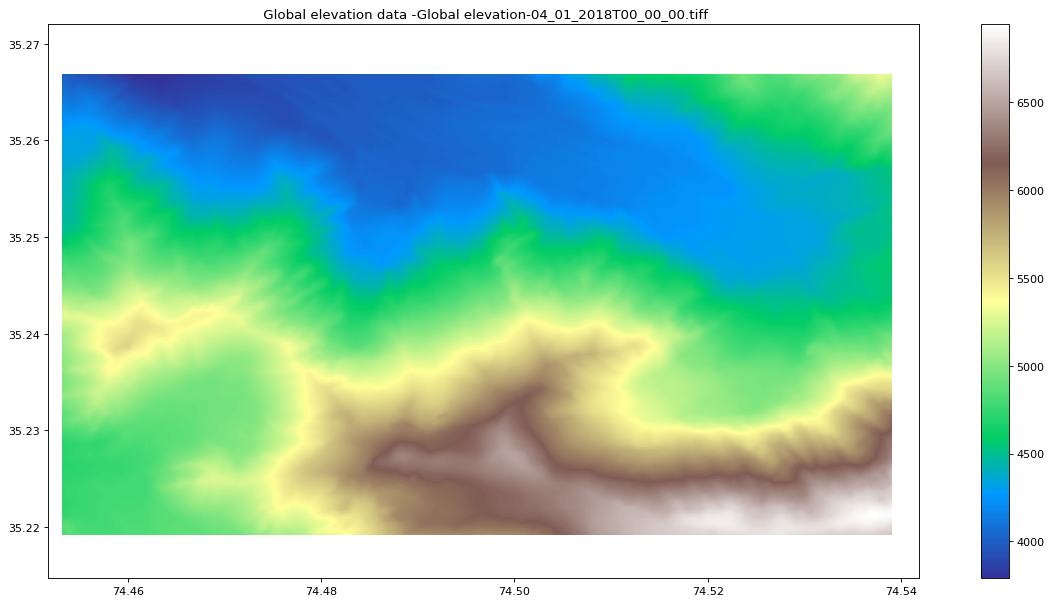

In [8]:
# Function to display the resulting Tiff(s).
global_elevation_file_list = global_elevation_result.list_files()
output_image_array = []
for file in global_elevation_file_list:
    if file.endswith('.tiff'): #display the raster images
        with open(file+'.json', 'r') as summary_file:
            fileparms = json.load(summary_file)
        boundingBox=fileparms["boundingBox"]
        pixelStatistics=fileparms["rasterStatistics"]
        myextent=[boundingBox["minLongitude"],
                  boundingBox["maxLongitude"],
                  boundingBox["minLatitude"],
                  boundingBox["maxLatitude" ] ]  
        array_global_elevation = np.array(PILImage.open(file))
        mask = (array_global_elevation == -9999)
        # Masked array to exclude NO Data points from plotting
        masked_array = np.ma.masked_array(array_global_elevation, mask)
        plt.figure(figsize = (20, 9), dpi=80) # Sets the size and resolution of the plot
        plt.imshow(masked_array,
                   cmap = 'terrain', 
                   vmin=pixelStatistics["pixelMin"], 
                   vmax=pixelStatistics["pixelMax"],
                   extent = myextent) # Loads the raster data and sets the colormap
        plt.colorbar() # Adds the color bar
        plt.title(" "+os.path.basename(file)) 
        output_image_path = os.path.splitext(os.path.basename(file))[0] + ".png"
        output_image_array.append(output_image_path)
        # Save the figure
        plt.savefig(output_image_path, bbox_inches='tight')
        plt.close() 

for output_image in output_image_array:
    #display the raster images
    display(Image(output_image,width=800, height=400))    

In the image above, the blue area denotes the areas with an elevation ranging from 4000 - 4500 metres above sea level, which transitions to green and yellow areas with an elevation between 4500 - 5500 meters above sea level, denoting slopy areas. As the elevation increases, we see further color transition to brown and white denoting the higher altitudes and mountain peak with higher elevations above 6000 meters above sea level.

## References
https://www.eorc.jaxa.jp/ALOS/en/dataset/aw3d30/aw3d30_e.htm

https://www.eorc.jaxa.jp/ALOS/en/index_e.htm